In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Convolution2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import skipgrams

C:\Users\liu0563\Miniconda3\envs\nlp\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
# Upload Data 

data = pd.read_csv("../wyns/data/tweet_global_warming.csv", encoding="latin")
print("Full dataset: {}".format(data.shape[0]))
data['existence'].fillna(value='Ambiguous', inplace = True) #replace NA's in existence with "ambiguous"
data['existence'].replace(('Y', 'N'), ('Yes', 'No'), inplace=True) #rename so encoder doesnt get confused
data = data.dropna() #now drop NA values
print("dataset without NaN: {}".format(data.shape[0]))

data['existence'][10:20]

Full dataset: 6090
dataset without NaN: 6087


10          Yes
11          Yes
12          Yes
13          Yes
14    Ambiguous
15          Yes
16          Yes
17           No
18          Yes
19          Yes
Name: existence, dtype: object

In [4]:
def read_data(data_file):
    for i, line in enumerate (data_file): 
        # do some pre-processing and return a list of words for each review text
        yield gensim.utils.simple_preprocess (line)

tweet_vocab = list(read_data(data['tweet']))

In [14]:
X = data.iloc[:,0] #store tweets in X 

labels = data.iloc[:,1]
confidence_interval = data.iloc[:,2]

# encode class as integers 
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels) 

# convert integers to one hot encoded
Y_one_hot = np_utils.to_categorical(encoded_Y)


# multiply one-hot by confidence intervals
Y=[]
for i, row in enumerate(confidence_interval):
    Y.append(row*Y_one_hot[i])
Y[0:5]
Y = np.array(Y)

In [15]:
Y[10:20]

array([[0.    , 0.    , 0.9073],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.5488],
       [0.    , 0.    , 0.8823],
       [1.    , 0.    , 0.    ],
       [0.    , 0.    , 0.75  ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.6648, 0.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.5194]], dtype=float32)

In [16]:
test_split = 0.8
train_size = int(len(X)*test_split)
test_size = len(X) - train_size
vector_size = 300
window_size = 10
max_tweet_length=28

indexes = set(np.random.choice(len(tweet_vocab), train_size + test_size, replace=False))

X_train = np.zeros((train_size, max_tweet_length, vector_size))
Y_train = np.zeros((train_size, 3), dtype=np.float32)
X_test = np.zeros((test_size, max_tweet_length, vector_size))
Y_test = np.zeros((test_size, 3), dtype=np.float32)

In [17]:
X.shape[0]

6087

In [18]:
list(inds[:10])

NameError: name 'inds' is not defined

In [20]:
# create a single array of processed data
XX = np.zeros((len(X),max_tweet_length, vector_size))
for i in range(XX.shape[0]):
    for j, twit in enumerate(tweet_vocab[i]):
        if twit not in X_vecs:
            continue
        XX[i,j,:] = X_vecs[twit]
# print(XX[:-10,:,:])
        
# print(XX.shape)




inds = np.arange(XX.shape[0])
np.random.shuffle(inds)
# print(inds)
train = list(inds[:X.shape[0]*3//4])
test = list(inds[X.shape[0]*3//4:])
X_train = XX[train]
X_train = X_train.reshape(*X_train.shape,1)
X_test = XX[test]
X_test = X_test.reshape(*X_test.shape,1)
Y_train = Y[train]
# Y_train = Y_train.reshape(*Y_train.shape,1)
Y_test = Y[test]
# Y_test = Y_test.reshape(*Y_test.shape,1)

In [10]:
google = gensim.models.KeyedVectors.load_word2vec_format('../wyns/data/GoogleNews-vectors-negative300.bin.gz',binary=True)
vocab = google.vocab.keys()
total_vocab = len(vocab)
print ("Set includes", total_vocab, "words")
X_vecs = google.wv
del google

Set includes 3000000 words


C:\Users\liu0563\Miniconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [61]:
np.floor(np.random.rand(3)*100)

array([78., 12., 23.])

In [74]:
X_resample, Y_resample = bootstrap(X_train,Y_train,10)

### A short video on how bagging works https://www.youtube.com/watch?v=2Mg8QD0F1dQ 

In [21]:
def bootstrap(X,Y, n=None):
#Bootstrap function
    if n == None:
        n = len(X)   
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    Y_resample = Y[resample_i]
    return X_resample, Y_resample

In [22]:
def bagging(n_sample,n_bag):
#Perform bagging procedure. Bootstrap and obtain an ensamble of models
    X_resample, Y_resample = bootstrap(X_train,Y_train, n_sample)
    bagModels = {}
    for i in range(n_bag):
        print("Model fitting on the {}th bootstrapped set".format(i+1))
        model = model_fit(X_resample,Y_resample)
        name = "model%s" % (i+1)
        bagModels[name] = model
    return bagModels

In [23]:
def model_fit(X_train,Y_train):
    filters = 32 #filter = 1 x KERNEL 
    inpurt_shape = (X_train.shape[1:])
    # create the model 
    model = Sequential()

    model.add(Convolution2D(16, kernel_size=3, activation='elu', padding='same',
                 input_shape=inpurt_shape))
    model.add(MaxPooling2D(pool_size=5))
    model.add(Convolution2D(filters=filters, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='linear')) #change from logistic 
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse']) 

    # Fit the model
    model.fit(X_train, 
              Y_train, 
              epochs=20, 
              batch_size=128,
              verbose=1)
    return model

In [24]:
def predict(bagModels):
# Model prediction for each bagged model before averaging 
    prediction = {}
    for i in bagModels:
        prediction[i] = bagModels[i].predict(X_test)
    return prediction

In [25]:
def conversion(prediction):
# Convert confidence values into prediction
    pred_list=[]
    for i in range(len(prediction)):
        index = np.argmax(prediction[i])
        if index == 0:
            pred = 'Ambiguous'
        elif index == 1:
            pred = 'No'
        else:
            pred = 'Yes'
        pred_list.append(pred)
    return pred_list

In [26]:
def baggedAccuracy(prediction,Y_test):
#Bagged accuracy calculation based on average confidences 
    sum_pred = 0
    for i in prediction:
        sum_pred += prediction[i]
    bagged_prediction = sum_pred/30
    bagged_list = conversion(bagged_prediction)
    Ytest_list = conversion(Y_test)
    correct_pred = sum(1 for i in range(len(bagged_list)) if bagged_list[i] == Ytest_list[i])
    baggedAccuracy = correct_pred/len(bagged_list) * 100
    return baggedAccuracy

First, we need to perform the splitting procedure as we did in the CNN notebook to get train and test sets <br/>
Now lets perform bagging of an ensamble of 50 models with each model containing 3800 bootstrapped samples from X_train

In [340]:
bagModel = bagging(3800,50)

Model fitting on the 1th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 201s 53ms/step - loss: 0.1491 - acc: 0.4853 - mean_squared_error: 0.1491
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1416 - acc: 0.5047 - mean_squared_error: 0.1416
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1409 - acc: 0.5047 - mean_squared_error: 0.1409
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1396 - acc: 0.5053 - mean_squared_error: 0.1396
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.5074 - mean_squared_error: 0.1378
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5129 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1311 - acc: 0.5321 - mean_squared_error: 0.1311
Epoch 8/20
3800/3800 [==============================] - 7s 2

Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1386 - acc: 0.5066 - mean_squared_error: 0.1386
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1355 - acc: 0.5142 - mean_squared_error: 0.1355
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1298 - acc: 0.5405 - mean_squared_error: 0.1298
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1243 - acc: 0.5697 - mean_squared_error: 0.1243
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1126 - acc: 0.6229 - mean_squared_error: 0.1126
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1012 - acc: 0.6782 - mean_squared_error: 0.1012
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0984 - acc: 0.6905 - mean_squared_error: 0.0984
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0901 - acc: 0.7282 - mean_squared_erro

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1179 - acc: 0.6082 - mean_squared_error: 0.1179
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1087 - acc: 0.6539 - mean_squared_error: 0.1087
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1009 - acc: 0.6858 - mean_squared_error: 0.1009
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0927 - acc: 0.7221 - mean_squared_error: 0.0927
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0846 - acc: 0.7461 - mean_squared_error: 0.0846
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0766 - acc: 0.7789 - mean_squared_error: 0.0766
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0699 - acc: 0.7987 - mean_squared_error: 0.0699
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0666 - acc: 0.8171 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0700 - acc: 0.7963 - mean_squared_error: 0.0700
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0672 - acc: 0.8034 - mean_squared_error: 0.0672
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0629 - acc: 0.8197 - mean_squared_error: 0.0629
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0591 - acc: 0.8389 - mean_squared_error: 0.0591
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0563 - acc: 0.8466 - mean_squared_error: 0.0563
Model fitting on the 17th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 12s 3ms/step - loss: 0.1499 - acc: 0.4895 - mean_squared_error: 0.1499
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1422 - acc: 0.5045 - mean_squared_error: 0.1422
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step 

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1417 - acc: 0.5047 - mean_squared_error: 0.1417
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1409 - acc: 0.5055 - mean_squared_error: 0.1409
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1397 - acc: 0.5058 - mean_squared_error: 0.1397
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1382 - acc: 0.5068 - mean_squared_error: 0.1382
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1348 - acc: 0.5137 - mean_squared_error: 0.1348
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1266 - acc: 0.5516 - mean_squared_error: 0.1266
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1179 - acc: 0.5887 - mean_squared_error: 0.1179
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1073 - acc: 0.6445 - mean_squared_error: 0.1073
Epo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1255 - acc: 0.5492 - mean_squared_error: 0.1255
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1160 - acc: 0.6089 - mean_squared_error: 0.1160
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1051 - acc: 0.6479 - mean_squared_error: 0.1051
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0977 - acc: 0.6824 - mean_squared_error: 0.0977
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0930 - acc: 0.7000 - mean_squared_error: 0.0930
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0853 - acc: 0.7303 - mean_squared_error: 0.0853
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0819 - acc: 0.7458 - mean_squared_error: 0.0819
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0778 - acc: 0.7655 - mean_squared_error: 0.07

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0740 - acc: 0.7855 - mean_squared_error: 0.0740
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0700 - acc: 0.7958 - mean_squared_error: 0.0700
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0638 - acc: 0.8171 - mean_squared_error: 0.0638
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0582 - acc: 0.8442 - mean_squared_error: 0.0582
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0543 - acc: 0.8484 - mean_squared_error: 0.0543
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0514 - acc: 0.8574 - mean_squared_error: 0.0514
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0482 - acc: 0.8721 - mean_squared_error: 0.0482
Model fitting on the 36th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 15s 4ms/ste

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0526 - acc: 0.8579 - mean_squared_error: 0.0526
Model fitting on the 42th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 14s 4ms/step - loss: 0.1530 - acc: 0.4792 - mean_squared_error: 0.1530
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1426 - acc: 0.5055 - mean_squared_error: 0.1426
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1403 - acc: 0.5061 - mean_squared_error: 0.1403
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1395 - acc: 0.5047 - mean_squared_error: 0.1395
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1391 - acc: 0.5053 - mean_squared_error: 0.1391
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1366 - acc: 0.5074 - mean_squared_error: 0.1366
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - lo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1394 - acc: 0.5066 - mean_squared_error: 0.1394
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1393 - acc: 0.5068 - mean_squared_error: 0.1393
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1367 - acc: 0.5071 - mean_squared_error: 0.1367
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1335 - acc: 0.5132 - mean_squared_error: 0.1335
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1297 - acc: 0.5408 - mean_squared_error: 0.1297
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1237 - acc: 0.5676 - mean_squared_error: 0.1237
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1169 - acc: 0.5974 - mean_squared_error: 0.1169
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1067 - acc: 0.6563 - mean_squared_error: 0.1067
Ep

### Bagging different numbers of models in an ensamble to test accuracy change

In [431]:
bagModel2 = bagging(3800,10)

Model fitting on the 1th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 19s 5ms/step - loss: 0.1500 - acc: 0.4782 - mean_squared_error: 0.1500
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1414 - acc: 0.4976 - mean_squared_error: 0.1414
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1398 - acc: 0.4984 - mean_squared_error: 0.1398
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.4989 - mean_squared_error: 0.1378
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1353 - acc: 0.5034 - mean_squared_error: 0.1353
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1308 - acc: 0.5176 - mean_squared_error: 0.1308
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1233 - acc: 0.5561 - mean_squared_error: 0.1233
Epoch 8/20
3800/3800 [==============================] - 7s 2ms

Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1388 - acc: 0.4997 - mean_squared_error: 0.1388
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.4987 - mean_squared_error: 0.1378
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5013 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1320 - acc: 0.5176 - mean_squared_error: 0.1320
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1281 - acc: 0.5289 - mean_squared_error: 0.1281
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1176 - acc: 0.5897 - mean_squared_error: 0.1176
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1059 - acc: 0.6516 - mean_squared_error: 0.1059
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0971 - acc: 0.6900 - mean_squared_erro

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1207 - acc: 0.5737 - mean_squared_error: 0.1207
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1124 - acc: 0.6145 - mean_squared_error: 0.1124
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1045 - acc: 0.6561 - mean_squared_error: 0.1045
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0990 - acc: 0.6726 - mean_squared_error: 0.0990
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0863 - acc: 0.7297 - mean_squared_error: 0.0863
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0811 - acc: 0.7487 - mean_squared_error: 0.0811
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0748 - acc: 0.7716 - mean_squared_error: 0.0748
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0718 - acc: 0.7866 - mean_squared_error: 0.0

In [465]:
bagged_predict.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29', 'model30', 'model31', 'model32', 'model33', 'model34', 'model35', 'model36', 'model37', 'model38', 'model39', 'model40', 'model41', 'model42', 'model43', 'model44', 'model45', 'model46', 'model47', 'model48', 'model49', 'model50'])

In [411]:
bagged_predict = predict(bagModel)

In [467]:
Accuracy= baggedAccuracy(bagged_predict,Y_test)
print("Bagged Accuracy(50 models): %.2f%% "%Accuracy)

Bagged Accuracy(50 models): 62.48% 


### Improved accuracy! Variance reduction helps!

In [435]:
bagModel2.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10'])

In [447]:
bag_pred2 = predict(bagModel2)

In [466]:
Accuracy2= baggedAccuracy(bag_pred2,Y_test)
print("Bagged Accuracy(10 models): %.2f%% "%Accuracy2)

Bagged Accuracy(10 models): 62.29% 


### The results for 10-model and 50-model ensamble are only slightly different

In [54]:
n_sample = int(len(X_train)*0.6)
n_sample

2739

In [57]:
model_num_list = [10,20,30,40,50]

In [33]:
def accuracy_bag(n_sample,model_num_list):
    model_bags = []
    accuracy_bags = []
    for i in model_num_list:
        print('Bagging {} models'.format(i))
        bagmodel = bagging(n_sample,i)
        bag_pred = predict(bagmodel)
        Accuracy = baggedAccuracy(bag_pred,Y_test)
        accuracy_bags.append(Accuracy)
    return accuracy_bags

I tried to get the accuracy of an ensamble from 1 to 50 models but my machine broke down overnight.. <br>I guess this is where GCP becomes handy. Next up: perform bagging for LSTM model. <br> You can see from the accuracy plot: 3/5 of the bagging accuracy is better than a single model accuracy without bagging(Single model accuracy 60.97 in this case). <br> Another point is as you randomly select observations for your training set and your bag size (the previous bagging accuracy was obtained by performing with another randomly selected training set and a bag size of 3800), the resulting accuracy can be different by several percentage. <br> I think bagging would help our model accuracy but not in a tremendous way. The results proved that the variance of our model was not signicant comparing to bias. Tune the hyperparameters!

In [ ]:
accuracybags = accuracy_bag(n_sample,model_num_list)

In [52]:
accuracybags

[61.62943495400789,
 60.2496714848883,
 63.929040735873855,
 63.074901445466494,
 60.775295663600524]

In [40]:
accuracybags_array = np.asarray(accuracybags)

In [38]:
from matplotlib import pyplot as plt

Text(0,0.5,'Bagging accuracy')

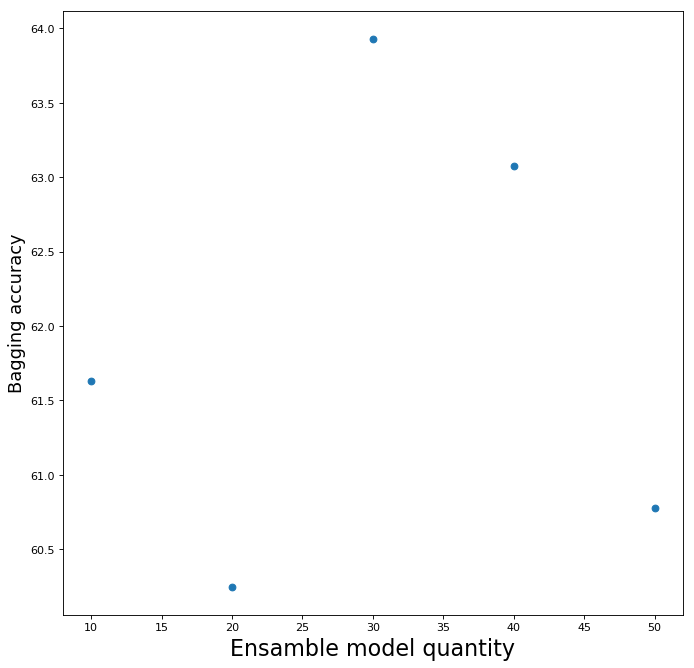

In [53]:
plt.figure(figsize=(10,10),dpi=80)
plt.scatter(model_num_list,accuracybags)
plt.xlabel('Ensamble model quantity',fontsize=20)
plt.ylabel('Bagging accuracy',fontsize=16)

The accuracy doesn't show an ascending trend as the ensamble contains more models, which is weird. 

Then I ran the model model for 3800 samples out of 4522 observations in the train set instead of 2639 samples with the same test train split.

In [ ]:
n_sample = 3800

In [58]:
accuracybag2 = accuracy_bag(n_sample,[20,30])

Bagging 20 models
Model fitting on the 1th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 27s 7ms/step - loss: 0.1513 - acc: 0.4847 - mean_squared_error: 0.1513
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1416 - acc: 0.5074 - mean_squared_error: 0.1416
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1403 - acc: 0.5076 - mean_squared_error: 0.1403
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1390 - acc: 0.5068 - mean_squared_error: 0.1390
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.5066 - mean_squared_error: 0.1378
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1367 - acc: 0.5068 - mean_squared_error: 0.1367
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1339 - acc: 0.5137 - mean_squared_error: 0.1339
Epoch 8/20
3800/3800 [==============================] - 7

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1387 - acc: 0.5071 - mean_squared_error: 0.1387
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1367 - acc: 0.5071 - mean_squared_error: 0.1367
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1327 - acc: 0.5089 - mean_squared_error: 0.1327
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1254 - acc: 0.5497 - mean_squared_error: 0.1254
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1173 - acc: 0.5942 - mean_squared_error: 0.1173
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1075 - acc: 0.6416 - mean_squared_error: 0.1075
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1012 - acc: 0.6629 - mean_squared_error: 0.1012
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0923 - acc: 0.7061 - mean_squared_error: 0.0923
E

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1282 - acc: 0.5300 - mean_squared_error: 0.1282
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1181 - acc: 0.5829 - mean_squared_error: 0.1181
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1096 - acc: 0.6371 - mean_squared_error: 0.1096
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0990 - acc: 0.6858 - mean_squared_error: 0.0990
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0887 - acc: 0.7247 - mean_squared_error: 0.0887
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0837 - acc: 0.7450 - mean_squared_error: 0.0837
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0760 - acc: 0.7771 - mean_squared_error: 0.0760
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0697 - acc: 0.7963 - mean_squared_error: 0.069

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1102 - acc: 0.6261 - mean_squared_error: 0.1102
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1009 - acc: 0.6805 - mean_squared_error: 0.1009
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0952 - acc: 0.7018 - mean_squared_error: 0.0952
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0922 - acc: 0.7124 - mean_squared_error: 0.0922
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0834 - acc: 0.7432 - mean_squared_error: 0.0834
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0801 - acc: 0.7576 - mean_squared_error: 0.0801
Epoch 16/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0736 - acc: 0.7797 - mean_squared_error: 0.0736
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0667 - acc: 0.8132 - mean_squared_error: 0.0

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1007 - acc: 0.6732 - mean_squared_error: 0.1007
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0905 - acc: 0.7208 - mean_squared_error: 0.0905
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0823 - acc: 0.7471 - mean_squared_error: 0.0823
Epoch 16/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0799 - acc: 0.7632 - mean_squared_error: 0.0799
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0716 - acc: 0.7966 - mean_squared_error: 0.0716
Epoch 18/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0667 - acc: 0.8092 - mean_squared_error: 0.0667
Epoch 19/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0610 - acc: 0.8318 - mean_squared_error: 0.0610
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0556 - acc: 0.8532 - mean_squared_error: 0.0

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0719 - acc: 0.7887 - mean_squared_error: 0.0719
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0650 - acc: 0.8176 - mean_squared_error: 0.0650
Epoch 18/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0591 - acc: 0.8361 - mean_squared_error: 0.0591
Epoch 19/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0563 - acc: 0.8439 - mean_squared_error: 0.0563
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0545 - acc: 0.8534 - mean_squared_error: 0.0545
Model fitting on the 17th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 17s 4ms/step - loss: 0.1514 - acc: 0.4908 - mean_squared_error: 0.1514
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1424 - acc: 0.5058 - mean_squared_error: 0.1424
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.141

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0521 - acc: 0.8658 - mean_squared_error: 0.0521
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0526 - acc: 0.8626 - mean_squared_error: 0.0526
Model fitting on the 20th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 17s 5ms/step - loss: 0.1507 - acc: 0.4821 - mean_squared_error: 0.1507
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1420 - acc: 0.5066 - mean_squared_error: 0.1420
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1404 - acc: 0.5066 - mean_squared_error: 0.1404
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1397 - acc: 0.5063 - mean_squared_error: 0.1397
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1382 - acc: 0.5066 - mean_squared_error: 0.1382
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1362 -

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1424 - acc: 0.4979 - mean_squared_error: 0.1424
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1418 - acc: 0.5011 - mean_squared_error: 0.1418
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1414 - acc: 0.5016 - mean_squared_error: 0.1414
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1401 - acc: 0.5003 - mean_squared_error: 0.1401
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1387 - acc: 0.5008 - mean_squared_error: 0.1387
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1356 - acc: 0.5105 - mean_squared_error: 0.1356
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1304 - acc: 0.5326 - mean_squared_error: 0.1304
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1247 - acc: 0.5621 - mean_squared_error: 0.1247
Epo

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1401 - acc: 0.5005 - mean_squared_error: 0.1401
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1385 - acc: 0.5061 - mean_squared_error: 0.1385
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5132 - mean_squared_error: 0.1356
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1288 - acc: 0.5461 - mean_squared_error: 0.1288
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1179 - acc: 0.6074 - mean_squared_error: 0.1179
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1088 - acc: 0.6513 - mean_squared_error: 0.1088
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0991 - acc: 0.6837 - mean_squared_error: 0.0991
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0925 - acc: 0.7071 - mean_squared_error: 0.0925


3800/3800 [==============================] - 8s 2ms/step - loss: 0.1169 - acc: 0.6055 - mean_squared_error: 0.1169
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1084 - acc: 0.6413 - mean_squared_error: 0.1084
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1002 - acc: 0.6818 - mean_squared_error: 0.1002
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0912 - acc: 0.7234 - mean_squared_error: 0.0912
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0840 - acc: 0.7437 - mean_squared_error: 0.0840
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0769 - acc: 0.7689 - mean_squared_error: 0.0769
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0742 - acc: 0.7768 - mean_squared_error: 0.0742
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0667 - acc: 0.8071 - mean_squared_error: 0.06

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0997 - acc: 0.6718 - mean_squared_error: 0.0997
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0887 - acc: 0.7208 - mean_squared_error: 0.0887
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0806 - acc: 0.7537 - mean_squared_error: 0.0806
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0736 - acc: 0.7792 - mean_squared_error: 0.0736
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0696 - acc: 0.7953 - mean_squared_error: 0.0696
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0644 - acc: 0.8168 - mean_squared_error: 0.0644
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0602 - acc: 0.8392 - mean_squared_error: 0.0602
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0549 - acc: 0.8553 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0807 - acc: 0.7382 - mean_squared_error: 0.0807
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0739 - acc: 0.7755 - mean_squared_error: 0.0739
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0711 - acc: 0.7818 - mean_squared_error: 0.0711
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0630 - acc: 0.8203 - mean_squared_error: 0.0630
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0590 - acc: 0.8313 - mean_squared_error: 0.0590
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0574 - acc: 0.8308 - mean_squared_error: 0.0574
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0531 - acc: 0.8547 - mean_squared_error: 0.0531
Model fitting on the 16th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 18s 5ms/step - loss: 0.1

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0621 - acc: 0.8211 - mean_squared_error: 0.0621
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0628 - acc: 0.8184 - mean_squared_error: 0.0628
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0564 - acc: 0.8455 - mean_squared_error: 0.0564
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0519 - acc: 0.8571 - mean_squared_error: 0.0519
Model fitting on the 19th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 20s 5ms/step - loss: 0.1531 - acc: 0.4768 - mean_squared_error: 0.1531
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1434 - acc: 0.5005 - mean_squared_error: 0.1434
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1417 - acc: 0.5016 - mean_squared_error: 0.1417
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1417

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0522 - acc: 0.8626 - mean_squared_error: 0.0522
Model fitting on the 22th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 20s 5ms/step - loss: 0.1526 - acc: 0.4800 - mean_squared_error: 0.1526
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1431 - acc: 0.4995 - mean_squared_error: 0.1431
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1418 - acc: 0.5011 - mean_squared_error: 0.1418
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1399 - acc: 0.5008 - mean_squared_error: 0.1399
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1391 - acc: 0.5039 - mean_squared_error: 0.1391
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1356 - acc: 0.5163 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1312 - 

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1422 - acc: 0.5005 - mean_squared_error: 0.1422
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1419 - acc: 0.5003 - mean_squared_error: 0.1419
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1399 - acc: 0.5037 - mean_squared_error: 0.1399
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1392 - acc: 0.5082 - mean_squared_error: 0.1392
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1351 - acc: 0.5218 - mean_squared_error: 0.1351
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1310 - acc: 0.5518 - mean_squared_error: 0.1310
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1274 - acc: 0.5555 - mean_squared_error: 0.1274
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1208 - acc: 0.5968 - mean_squared_error: 0.1208
Ep

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1385 - acc: 0.5063 - mean_squared_error: 0.1385
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1349 - acc: 0.5137 - mean_squared_error: 0.1349
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1331 - acc: 0.5253 - mean_squared_error: 0.1331
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1231 - acc: 0.5745 - mean_squared_error: 0.1231
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1110 - acc: 0.6258 - mean_squared_error: 0.1110
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1023 - acc: 0.6639 - mean_squared_error: 0.1023
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0917 - acc: 0.7068 - mean_squared_error: 0.0917
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0843 - acc: 0.7374 - mean_squared_error: 0.0843

In [60]:
accuracybag3 = accuracy_bag(n_sample,[40,50])

Bagging 40 models
Model fitting on the 1th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 117s 31ms/step - loss: 0.1507 - acc: 0.4966 - mean_squared_error: 0.1507
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1412 - acc: 0.5087 - mean_squared_error: 0.1412
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1398 - acc: 0.5079 - mean_squared_error: 0.1398
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1393 - acc: 0.5084 - mean_squared_error: 0.1393
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1375 - acc: 0.5087 - mean_squared_error: 0.1375
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5105 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1330 - acc: 0.5137 - mean_squared_error: 0.1330
Epoch 8/20
3800/3800 [==============================] -

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1388 - acc: 0.5105 - mean_squared_error: 0.1388
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1369 - acc: 0.5108 - mean_squared_error: 0.1369
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1354 - acc: 0.5147 - mean_squared_error: 0.1354
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1310 - acc: 0.5258 - mean_squared_error: 0.1310
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1243 - acc: 0.5584 - mean_squared_error: 0.1243
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1196 - acc: 0.5987 - mean_squared_error: 0.1196
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1098 - acc: 0.6366 - mean_squared_error: 0.1098
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1015 - acc: 0.6713 - mean_squared_error: 0.1015
E

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1281 - acc: 0.5405 - mean_squared_error: 0.1281
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1195 - acc: 0.5905 - mean_squared_error: 0.1195
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1075 - acc: 0.6429 - mean_squared_error: 0.1075
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1006 - acc: 0.6782 - mean_squared_error: 0.1006
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0923 - acc: 0.7155 - mean_squared_error: 0.0923
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0829 - acc: 0.7561 - mean_squared_error: 0.0829
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0786 - acc: 0.7650 - mean_squared_error: 0.0786
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0703 - acc: 0.7974 - mean_squared_error: 0.070

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0952 - acc: 0.6971 - mean_squared_error: 0.0952
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0900 - acc: 0.7153 - mean_squared_error: 0.0900
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0836 - acc: 0.7400 - mean_squared_error: 0.0836
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0775 - acc: 0.7711 - mean_squared_error: 0.0775
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0715 - acc: 0.7903 - mean_squared_error: 0.0715
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0715 - acc: 0.7900 - mean_squared_error: 0.0715
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0662 - acc: 0.8079 - mean_squared_error: 0.0662
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0592 - acc: 0.8326 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0938 - acc: 0.6987 - mean_squared_error: 0.0938
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0857 - acc: 0.7318 - mean_squared_error: 0.0857
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0782 - acc: 0.7621 - mean_squared_error: 0.0782
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0781 - acc: 0.7608 - mean_squared_error: 0.0781
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0696 - acc: 0.7979 - mean_squared_error: 0.0696
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0635 - acc: 0.8203 - mean_squared_error: 0.0635
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0617 - acc: 0.8279 - mean_squared_error: 0.0617
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0555 - acc: 0.8526 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0715 - acc: 0.7903 - mean_squared_error: 0.0715
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0679 - acc: 0.8068 - mean_squared_error: 0.0679
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0642 - acc: 0.8163 - mean_squared_error: 0.0642
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0617 - acc: 0.8245 - mean_squared_error: 0.0617
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0567 - acc: 0.8437 - mean_squared_error: 0.0567
Model fitting on the 17th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 20s 5ms/step - loss: 0.1467 - acc: 0.5013 - mean_squared_error: 0.1467
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1411 - acc: 0.5068 - mean_squared_error: 0.1411
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.139

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0494 - acc: 0.8705 - mean_squared_error: 0.0494
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0453 - acc: 0.8889 - mean_squared_error: 0.0453
Model fitting on the 20th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 20s 5ms/step - loss: 0.1496 - acc: 0.4997 - mean_squared_error: 0.1496
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1403 - acc: 0.5097 - mean_squared_error: 0.1403
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1391 - acc: 0.5097 - mean_squared_error: 0.1391
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1374 - acc: 0.5100 - mean_squared_error: 0.1374
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1363 - acc: 0.5171 - mean_squared_error: 0.1363
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1334 -

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1419 - acc: 0.5058 - mean_squared_error: 0.1419
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1402 - acc: 0.5111 - mean_squared_error: 0.1402
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1381 - acc: 0.5121 - mean_squared_error: 0.1381
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1381 - acc: 0.5121 - mean_squared_error: 0.1381
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1350 - acc: 0.5163 - mean_squared_error: 0.1350
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1315 - acc: 0.5292 - mean_squared_error: 0.1315
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1266 - acc: 0.5545 - mean_squared_error: 0.1266
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1192 - acc: 0.5866 - mean_squared_error: 0.1192
Epo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1363 - acc: 0.5142 - mean_squared_error: 0.1363
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1333 - acc: 0.5239 - mean_squared_error: 0.1333
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1306 - acc: 0.5397 - mean_squared_error: 0.1306
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1212 - acc: 0.5826 - mean_squared_error: 0.1212
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1151 - acc: 0.6108 - mean_squared_error: 0.1151
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1025 - acc: 0.6563 - mean_squared_error: 0.1025
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0927 - acc: 0.7000 - mean_squared_error: 0.0927
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0871 - acc: 0.7308 - mean_squared_error: 0.0871


3800/3800 [==============================] - 7s 2ms/step - loss: 0.1168 - acc: 0.6013 - mean_squared_error: 0.1168
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1073 - acc: 0.6403 - mean_squared_error: 0.1073
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1001 - acc: 0.6666 - mean_squared_error: 0.1001
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0941 - acc: 0.7050 - mean_squared_error: 0.0941
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0854 - acc: 0.7339 - mean_squared_error: 0.0854
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0787 - acc: 0.7613 - mean_squared_error: 0.0787
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0733 - acc: 0.7755 - mean_squared_error: 0.0733
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0681 - acc: 0.7984 - mean_squared_error: 0.06

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1079 - acc: 0.6405 - mean_squared_error: 0.1079
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0978 - acc: 0.6918 - mean_squared_error: 0.0978
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0915 - acc: 0.7171 - mean_squared_error: 0.0915
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0874 - acc: 0.7263 - mean_squared_error: 0.0874
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0778 - acc: 0.7734 - mean_squared_error: 0.0778
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0719 - acc: 0.7908 - mean_squared_error: 0.0719
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0673 - acc: 0.8132 - mean_squared_error: 0.0673
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0602 - acc: 0.8284 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0737 - acc: 0.7750 - mean_squared_error: 0.0737
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0673 - acc: 0.8005 - mean_squared_error: 0.0673
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0630 - acc: 0.8229 - mean_squared_error: 0.0630
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0595 - acc: 0.8342 - mean_squared_error: 0.0595
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0555 - acc: 0.8476 - mean_squared_error: 0.0555
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0507 - acc: 0.8708 - mean_squared_error: 0.0507
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0471 - acc: 0.8776 - mean_squared_error: 0.0471
Model fitting on the 36th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 21s 5ms/step - loss: 0.1

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0631 - acc: 0.8266 - mean_squared_error: 0.0631
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0601 - acc: 0.8313 - mean_squared_error: 0.0601
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0554 - acc: 0.8521 - mean_squared_error: 0.0554
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0503 - acc: 0.8726 - mean_squared_error: 0.0503
Model fitting on the 39th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 21s 6ms/step - loss: 0.1481 - acc: 0.4963 - mean_squared_error: 0.1481
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1411 - acc: 0.5082 - mean_squared_error: 0.1411
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1402 - acc: 0.5095 - mean_squared_error: 0.1402
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1387

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0588 - acc: 0.8374 - mean_squared_error: 0.0588
Model fitting on the 2th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 23s 6ms/step - loss: 0.1474 - acc: 0.4947 - mean_squared_error: 0.1474
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1401 - acc: 0.5150 - mean_squared_error: 0.1401
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1381 - acc: 0.5134 - mean_squared_error: 0.1381
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1365 - acc: 0.5137 - mean_squared_error: 0.1365
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1346 - acc: 0.5153 - mean_squared_error: 0.1346
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1315 - acc: 0.5203 - mean_squared_error: 0.1315
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1261 - a

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1375 - acc: 0.5179 - mean_squared_error: 0.1375
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1354 - acc: 0.5153 - mean_squared_error: 0.1354
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1335 - acc: 0.5216 - mean_squared_error: 0.1335
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1313 - acc: 0.5229 - mean_squared_error: 0.1313
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1263 - acc: 0.5518 - mean_squared_error: 0.1263
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1179 - acc: 0.5971 - mean_squared_error: 0.1179
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1101 - acc: 0.6255 - mean_squared_error: 0.1101
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1026 - acc: 0.6613 - mean_squared_error: 0.1026
Ep

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1346 - acc: 0.5142 - mean_squared_error: 0.1346
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1323 - acc: 0.5245 - mean_squared_error: 0.1323
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1285 - acc: 0.5408 - mean_squared_error: 0.1285
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1189 - acc: 0.5761 - mean_squared_error: 0.1189
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1134 - acc: 0.6108 - mean_squared_error: 0.1134
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1052 - acc: 0.6434 - mean_squared_error: 0.1052
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0968 - acc: 0.6842 - mean_squared_error: 0.0968
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0885 - acc: 0.7221 - mean_squared_error: 0.0885

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1177 - acc: 0.5929 - mean_squared_error: 0.1177
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1107 - acc: 0.6224 - mean_squared_error: 0.1107
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1015 - acc: 0.6703 - mean_squared_error: 0.1015
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0939 - acc: 0.7024 - mean_squared_error: 0.0939
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0856 - acc: 0.7413 - mean_squared_error: 0.0856
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0808 - acc: 0.7532 - mean_squared_error: 0.0808
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0737 - acc: 0.7845 - mean_squared_error: 0.0737
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0665 - acc: 0.8182 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0979 - acc: 0.6789 - mean_squared_error: 0.0979
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0898 - acc: 0.7182 - mean_squared_error: 0.0898
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0826 - acc: 0.7521 - mean_squared_error: 0.0826
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0772 - acc: 0.7711 - mean_squared_error: 0.0772
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0714 - acc: 0.7942 - mean_squared_error: 0.0714
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0695 - acc: 0.7932 - mean_squared_error: 0.0695
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0637 - acc: 0.8174 - mean_squared_error: 0.0637
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0595 - acc: 0.8350 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0720 - acc: 0.7868 - mean_squared_error: 0.0720
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0697 - acc: 0.7989 - mean_squared_error: 0.0697
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0643 - acc: 0.8184 - mean_squared_error: 0.0643
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0587 - acc: 0.8421 - mean_squared_error: 0.0587
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0554 - acc: 0.8503 - mean_squared_error: 0.0554
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0538 - acc: 0.8545 - mean_squared_error: 0.0538
Model fitting on the 18th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 34s 9ms/step - loss: 0.1515 - acc: 0.4992 - mean_squared_error: 0.1515
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.14

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0590 - acc: 0.8387 - mean_squared_error: 0.0590
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0523 - acc: 0.8595 - mean_squared_error: 0.0523
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0478 - acc: 0.8800 - mean_squared_error: 0.0478
Model fitting on the 21th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 28s 7ms/step - loss: 0.1527 - acc: 0.4929 - mean_squared_error: 0.1527
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1399 - acc: 0.5129 - mean_squared_error: 0.1399
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1393 - acc: 0.5132 - mean_squared_error: 0.1393
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1383 - acc: 0.5139 - mean_squared_error: 0.1383
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1375 

3800/3800 [==============================] - 24s 6ms/step - loss: 0.1489 - acc: 0.4961 - mean_squared_error: 0.1489
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1393 - acc: 0.5134 - mean_squared_error: 0.1393
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1389 - acc: 0.5139 - mean_squared_error: 0.1389
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1372 - acc: 0.5161 - mean_squared_error: 0.1372
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1360 - acc: 0.5168 - mean_squared_error: 0.1360
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1348 - acc: 0.5166 - mean_squared_error: 0.1348
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1307 - acc: 0.5258 - mean_squared_error: 0.1307
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1244 - acc: 0.5658 - mean_squared_error: 0.1244
Ep

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1373 - acc: 0.5137 - mean_squared_error: 0.1373
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1364 - acc: 0.5137 - mean_squared_error: 0.1364
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1347 - acc: 0.5147 - mean_squared_error: 0.1347
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1326 - acc: 0.5184 - mean_squared_error: 0.1326
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1269 - acc: 0.5476 - mean_squared_error: 0.1269
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1200 - acc: 0.5805 - mean_squared_error: 0.1200
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1118 - acc: 0.6282 - mean_squared_error: 0.1118
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1044 - acc: 0.6674 - mean_squared_error: 0.1044
E

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1244 - acc: 0.5605 - mean_squared_error: 0.1244
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1175 - acc: 0.5911 - mean_squared_error: 0.1175
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1103 - acc: 0.6255 - mean_squared_error: 0.1103
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1035 - acc: 0.6545 - mean_squared_error: 0.1035
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0953 - acc: 0.6963 - mean_squared_error: 0.0953
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0886 - acc: 0.7132 - mean_squared_error: 0.0886
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0830 - acc: 0.7303 - mean_squared_error: 0.0830
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0782 - acc: 0.7542 - mean_squared_error: 0.078

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1117 - acc: 0.6263 - mean_squared_error: 0.1117
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1033 - acc: 0.6534 - mean_squared_error: 0.1033
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0957 - acc: 0.6882 - mean_squared_error: 0.0957
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0874 - acc: 0.7279 - mean_squared_error: 0.0874
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0840 - acc: 0.7366 - mean_squared_error: 0.0840
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0759 - acc: 0.7705 - mean_squared_error: 0.0759
Epoch 16/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0713 - acc: 0.7876 - mean_squared_error: 0.0713
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0651 - acc: 0.8116 - mean_squared_error: 0.0

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0896 - acc: 0.7174 - mean_squared_error: 0.0896
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0810 - acc: 0.7505 - mean_squared_error: 0.0810
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0747 - acc: 0.7789 - mean_squared_error: 0.0747
Epoch 16/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0692 - acc: 0.8018 - mean_squared_error: 0.0692
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0653 - acc: 0.8234 - mean_squared_error: 0.0653
Epoch 18/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0595 - acc: 0.8339 - mean_squared_error: 0.0595
Epoch 19/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0614 - acc: 0.8311 - mean_squared_error: 0.0614
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0550 - acc: 0.8505 - mean_squared_error: 0.0

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0650 - acc: 0.8197 - mean_squared_error: 0.0650
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0628 - acc: 0.8300 - mean_squared_error: 0.0628
Epoch 18/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0561 - acc: 0.8503 - mean_squared_error: 0.0561
Epoch 19/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0516 - acc: 0.8700 - mean_squared_error: 0.0516
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0479 - acc: 0.8821 - mean_squared_error: 0.0479
Model fitting on the 40th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 25s 7ms/step - loss: 0.1472 - acc: 0.4963 - mean_squared_error: 0.1472
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1386 - acc: 0.5137 - mean_squared_error: 0.1386
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.137

3800/3800 [==============================] - 8s 2ms/step - loss: 0.0546 - acc: 0.8516 - mean_squared_error: 0.0546
Epoch 20/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0515 - acc: 0.8689 - mean_squared_error: 0.0515
Model fitting on the 43th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 26s 7ms/step - loss: 0.1508 - acc: 0.4958 - mean_squared_error: 0.1508
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1398 - acc: 0.5129 - mean_squared_error: 0.1398
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1388 - acc: 0.5137 - mean_squared_error: 0.1388
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1380 - acc: 0.5147 - mean_squared_error: 0.1380
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1372 - acc: 0.5163 - mean_squared_error: 0.1372
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1353 -

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1391 - acc: 0.5134 - mean_squared_error: 0.1391
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1374 - acc: 0.5150 - mean_squared_error: 0.1374
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1369 - acc: 0.5163 - mean_squared_error: 0.1369
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1351 - acc: 0.5176 - mean_squared_error: 0.1351
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1354 - acc: 0.5189 - mean_squared_error: 0.1354
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1300 - acc: 0.5253 - mean_squared_error: 0.1300
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1274 - acc: 0.5437 - mean_squared_error: 0.1274
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1190 - acc: 0.5747 - mean_squared_error: 0.1190
Epo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1367 - acc: 0.5166 - mean_squared_error: 0.1367
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1348 - acc: 0.5192 - mean_squared_error: 0.1348
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1325 - acc: 0.5274 - mean_squared_error: 0.1325
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1289 - acc: 0.5313 - mean_squared_error: 0.1289
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1239 - acc: 0.5508 - mean_squared_error: 0.1239
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1174 - acc: 0.5921 - mean_squared_error: 0.1174
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1097 - acc: 0.6258 - mean_squared_error: 0.1097
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0995 - acc: 0.6774 - mean_squared_error: 0.0995


In [66]:
accuracybag4 = accuracy_bag(n_sample,[10])

Bagging 10 models
Model fitting on the 1th bootstrapped set
Epoch 1/20
3800/3800 [==============================] - 299s 79ms/step - loss: 0.1503 - acc: 0.4837 - mean_squared_error: 0.1503
Epoch 2/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1414 - acc: 0.5063 - mean_squared_error: 0.1414
Epoch 3/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1403 - acc: 0.5063 - mean_squared_error: 0.1403
Epoch 4/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1382 - acc: 0.5087 - mean_squared_error: 0.1382
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1372 - acc: 0.5063 - mean_squared_error: 0.1372
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1323 - acc: 0.5179 - mean_squared_error: 0.1323
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1262 - acc: 0.5442 - mean_squared_error: 0.1262
Epoch 8/20
3800/3800 [==============================] -

3800/3800 [==============================] - 9s 2ms/step - loss: 0.1398 - acc: 0.5084 - mean_squared_error: 0.1398
Epoch 5/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1395 - acc: 0.5084 - mean_squared_error: 0.1395
Epoch 6/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1378 - acc: 0.5074 - mean_squared_error: 0.1378
Epoch 7/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1350 - acc: 0.5074 - mean_squared_error: 0.1350
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1319 - acc: 0.5200 - mean_squared_error: 0.1319
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1241 - acc: 0.5692 - mean_squared_error: 0.1241
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1169 - acc: 0.6116 - mean_squared_error: 0.1169
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1058 - acc: 0.6511 - mean_squared_error: 0.1058
E

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1293 - acc: 0.5334 - mean_squared_error: 0.1293
Epoch 8/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1225 - acc: 0.5739 - mean_squared_error: 0.1225
Epoch 9/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1116 - acc: 0.6268 - mean_squared_error: 0.1116
Epoch 10/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1030 - acc: 0.6616 - mean_squared_error: 0.1030
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0987 - acc: 0.6876 - mean_squared_error: 0.0987
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0916 - acc: 0.7111 - mean_squared_error: 0.0916
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0831 - acc: 0.7371 - mean_squared_error: 0.0831
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0774 - acc: 0.7666 - mean_squared_error: 0.077

3800/3800 [==============================] - 8s 2ms/step - loss: 0.1133 - acc: 0.6226 - mean_squared_error: 0.1133
Epoch 11/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.1021 - acc: 0.6684 - mean_squared_error: 0.1021
Epoch 12/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0960 - acc: 0.6947 - mean_squared_error: 0.0960
Epoch 13/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0890 - acc: 0.7279 - mean_squared_error: 0.0890
Epoch 14/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0838 - acc: 0.7442 - mean_squared_error: 0.0838
Epoch 15/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0807 - acc: 0.7537 - mean_squared_error: 0.0807
Epoch 16/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0730 - acc: 0.7800 - mean_squared_error: 0.0730
Epoch 17/20
3800/3800 [==============================] - 8s 2ms/step - loss: 0.0719 - acc: 0.7871 - mean_squared_error: 0.0

In [59]:
accuracybag2

[62.155059132720105, 64.71747700394218]

In [61]:
accuracybag3

[63.666228646517744, 64.0604467805519]

I did the bagging separately because I was afraid of my machine breaking down..

In [70]:
accuracy_3800sample = accuracybag4 +accuracybag2 + accuracybag3

In [73]:
accuracy_2640sample = accuracybags

In [71]:
accuracy_3800sample 

[61.826544021024965,
 62.155059132720105,
 64.71747700394218,
 63.666228646517744,
 64.0604467805519]

### Combine the accuracy results for 2640 and 3800 samples for (10,20,30,40,50) models bagging

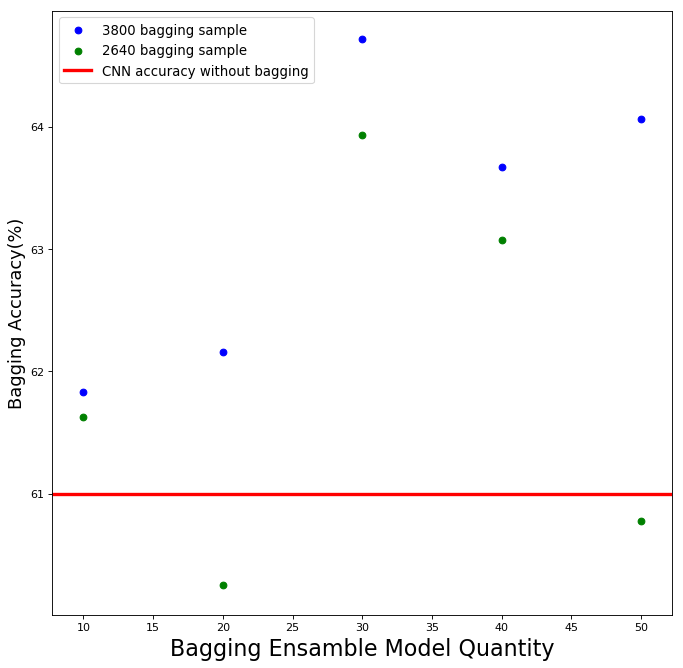

In [101]:
plt.figure(figsize=(10,10),dpi=80)
scatter_3800sample = plt.scatter([10,20,30,40,50],accuracy_3800sample,color = 'Blue')
scatter_2640sample = plt.scatter([10,20,30,40,50],accuracy_2640sample,color = 'Green')
plt.xlabel('Bagging Ensamble Model Quantity',fontsize=20)
plt.ylabel('Bagging Accuracy(%)',fontsize=16)
CNN_accuracy = plt.axhline(61, color="red",lw =3)
plt.legend((scatter_3800sample,scatter_2640sample,CNN_accuracy), ('3800 bagging sample', '2640 bagging sample','CNN accuracy without bagging'),loc = 'upper left',fontsize = 12)

I tried to get the accuracy bags from 1 to 50 models but my machine broke down overnight.. <br>I guess this is where GCP becomes handy. Next up: perform bagging for LSTM model. <br> You can see from the accuracy plot: 3/5 of the bagging accuracy is better than a single model accuracy without bagging(Single model accuracy 60.97 in this case). <br> Another point is as you randomly select observations for your training set and your bag size (the previous bagging accuracy was obtained by performing with another randomly selected training set and a bag size of 3800), the resulting accuracy can be different by several percentage. <br> I think bagging would help our model accuracy but not in a tremendous way. The results proved that the variance of our model was not signicant comparing to bias. Tune the hyperparameters!

### Please correct me if there is any problem in the code!!!

The following cells are for trying to see if finding the most common prediction among models (voting) in the ensamble gives better results than averging the confidence values then make predictions 

In [22]:
from collections import Counter

In [341]:
bagModel.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29', 'model30', 'model31', 'model32', 'model33', 'model34', 'model35', 'model36', 'model37', 'model38', 'model39', 'model40', 'model41', 'model42', 'model43', 'model44', 'model45', 'model46', 'model47', 'model48', 'model49', 'model50'])

In [321]:
lists = []
for i in range(30):
    model_number = "model%s" % (i+1)
    pred_list = conversion(prediction[model_number])
    lists.append(pred_list)

In [ ]:
Ytest_list=conversion(Y_test)

In [334]:
pred_list = []
for i in range(1522):
    for j in range(30):
        new_list = []
        new_list.append(lists[j][i])
        pred = Counter(new_list).most_common(1)[0][0]
    pred_list.append(pred)

In [337]:
sum(1 for i in range(len(pred_list)) if pred_list[i] == Ytest_list[i])

836

# The result is worse!

In [50]:
from keras.layers import Dropout, Convolution2D, MaxPooling2D

top_words = 1000
max_words = 150
filters = 32 #filter = 1 x KERNEL 

inpurt_shape = (X_train.shape[1:])
print(inpurt_shape)
# create the model 
model = Sequential()

model.add(Convolution2D(16, kernel_size=3, activation='elu', padding='same',
                 input_shape=inpurt_shape))
model.add(MaxPooling2D(pool_size=5))
model.add(Convolution2D(filters=filters, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='linear')) #change from logistic 
model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse']) 
print(model.summary())

# Fit the model
model.fit(X_train, 
          Y_train, 
          validation_data=(X_test, Y_test), 
          epochs=20, 
          batch_size=128,
          verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(28, 300, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_305 (Conv2D)          (None, 28, 300, 16)       160       
_________________________________________________________________
max_pooling2d_305 (MaxPoolin (None, 5, 60, 16)         0         
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 5, 60, 32)         4640      
_________________________________________________________________
max_pooling2d_306 (MaxPoolin (None, 1, 12, 32)         0         
_________________________________________________________________
flatten_153 (Flatten)        (None, 384)               0         
_________________________________________________________________
dense_457 (Dense)            (None, 250)               96250     
_________________________________________________________________
dense_458 (Dense)            (None, 250)               62750   